## Import libraries

In [1]:
import datetime
from datetime import datetime

import numpy as np
import pandas as pd

import gensim
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel

import spacy 
from spacy import displacy

import matplotlib.pyplot as plt

import pickle
import os
import sys
sys.path.append(os.path.join(os.environ['PWD'],'scripts'))

from scrap import get_comments
from preprocess_text import preprocess_raw_comments

## Collect comments for January 2022

In [2]:
data_path = os.path.join(os.environ['PWD'],'data/january_comments.pkl')

if not os.path.isfile(data_path):
    start_date = datetime.strptime('2022-01-01',"%Y-%m-%d")
    end_date = datetime.strptime('2022-02-01',"%Y-%m-%d")
    
    raw_comments = get_comments(start_date, end_date) 
    
    pickling_on = open(data_path,"wb")
    pickle.dump(raw_comments, pickling_on)
    pickling_on.close()
    print('data pickled successfully!')
else:
    pickle_off = open(data_path, 'rb')
    raw_comments = pickle.load(pickle_off)
    print('data unpickled successfully!')

data unpickled successfully!


In [3]:
len(raw_comments)

453

## Preprocess textual data for analysis

In [4]:
data_path = os.path.join(os.environ['PWD'],'data/january_comments_processed.pkl')

if not os.path.isfile(data_path):

    preprocessed_text = preprocess_raw_comments(raw_comments) 
    
    pickling_on = open(data_path,"wb")
    pickle.dump(preprocessed_text, pickling_on)
    pickling_on.close()
    print('data pickled successfully!')
else:
    pickle_off = open(data_path, 'rb')
    preprocessed_text = pickle.load(pickle_off)
    print('data unpickled successfully!')

data unpickled successfully!


## Analyse rating scores

In [5]:
preprocessed_text['ratings']

pos  neg
Career Growth      288   83
Work Satisfaction  297   80
Job Security       324   63
Skill Development  325   66
Work-Life Balance  326   62
Salary & Benefits  351   50
Company Culture    382   35

- Positive and Negative categories are highly negatively correlated
- Overall employees are mostly satisfied with company culture, salary and benefits
- Overall employees are mostly dissatisfied with career growth and work satisfaction

## Analyse comments

### Positive comments

In [6]:
data_path = os.path.join(os.environ['PWD'],'data/pos_comments_models.pkl')

if not os.path.isfile(data_path):
    per_values = []
    coh_values = []
    coh_models = []
    lda_models = []
    for i in range(1,30):
    
        lda_model = LdaModel(corpus=preprocessed_text['pos_corpus'], num_topics=i, 
                                             id2word=preprocessed_text['pos_dictionary'],chunksize=10, passes=2)
    
        perplexity = lda_model.log_perplexity(preprocessed_text['pos_corpus'])
    
        coh_model = CoherenceModel(model=lda_model, texts=preprocessed_text['pos_texts'], 
                            dictionary=preprocessed_text['pos_dictionary'],coherence='c_v')

        coherence = coh_model.get_coherence()  # get coherence value
    
        per_values.append(perplexity)
        coh_values.append(coherence)
        coh_models.append(coh_model)
        lda_models.append(lda_model) 
        
    pos_topic_models = {}
    pos_topic_models['per_values'] = per_values
    pos_topic_models['coh_values'] = coh_values
    pos_topic_models['coh_models'] = coh_models
    pos_topic_models['lda_models'] = lda_models
    
    pickling_on = open(data_path,"wb")
    pickle.dump(pos_topic_models, pickling_on)
    pickling_on.close()
    print('data pickled successfully!')
else:
    pickle_off = open(data_path, 'rb')
    pos_topic_models = pickle.load(pickle_off)
    print('data unpickled successfully!')

data unpickled successfully!


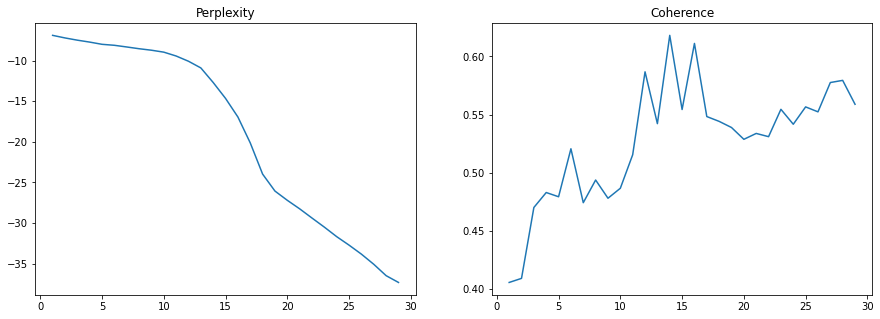

In [7]:
figure, axis = plt.subplots(1, 2, figsize=(15,5))

axis[0].plot(range(1,30), pos_topic_models['per_values'])
axis[0].set_title("Perplexity")
  
axis[1].plot(range(1,30), pos_topic_models['coh_values'])
axis[1].set_title("Coherence")
  
plt.show()

I choose 7 topics for evaluation, it is local maximum for coherence, and higher number of topics induce too much overlapping topics

In [8]:
n_topics = 7
lda_model = pos_topic_models['lda_models'][n_topics-1]
dictionary = preprocessed_text['pos_dictionary']

In [9]:
data_frame = pd.DataFrame()
for i in range(n_topics):
    data_frame['Topic'+str(i)] = pd.Series(index=dictionary.values(),data=lda_model.get_topics()[i]).sort_values(ascending=False).index.values

In [10]:
data_frame.iloc[:20]

Topic0              Topic1        Topic2           Topic3  \
0        opportunity          management       benefit          culture   
1          knowledge                give         shift            great   
2              extra                gift         skill             like   
3               year             support  life_balance   company_policy   
4               hour              senior         leave           target   
5           internal        start_career        people  security_depend   
6                way            maintain      employee      unrealistic   
7             leader                  ok  organization             join   
8               come             resolve          peak      working_day   
9               high                  cx    supportive            level   
10     career_growth       big_advantage          home          politic   
11      compensation             problem        minute              day   
12           provide                  hr          love             life   
13             thank                talk    nice_place         facility   
14           resolve          waste_time    enjoy_work      corporation   
15                cx               email   accordingly          privide   
16             money              metric        growth            style   
17         allowance            friendly      possible            worry   
18  customer_service              family          need      big_company   
19      satisfaction  supportive_manager       holiday           strict   

                    Topic4                Topic5          Topic6  
0                  company                  work            time  
1                excellent                 learn      experience  
2                   policy               overall         amazing  
3      environment_culture                   lot            good  
4   management_transparent                 month            team  
5      teammate_supportive                salary        security  
6                 customer              give_lot      atmosphere  
7                       go               fresher           place  
8                wonderful              training           thing  
9                  process                  step            want  
10              e_commerce  culture_compensation             bad  
11             transparent                  know            nice  
12    environment_teammate                   pay        delivery  
13   supportive_management             like_work           bound  
14           great_company           great_place          handel  
15                   chill                    ys         inbound  
16                   dream                  feel             ing  
17             salary_hike               benifit  infrastructure  
18         time_management                   mnc             get  
19          huge_cafeteria                gender               üôÇ

- Employees from first group of comments are most satisfied with opportunities to carrer growth. Words like: opportunity, carrer growth indicate this
- Employees from second group of comments are most satisfied with management. Words like: management, support, senior indicate this
- Employees from third group of comments are most satisfied with benefits and life balance. Words like: benefit, life balance, holiday indicate this
- Employees from fourth group of comments are most satisfied with culture and company policy. Words like: culture, company policy indicate this
- Employees from fifth group of comments are most satisfied with culture, management and teammates. Words like: environment culture, supportive and transparent management, supportive management indicate this
- Employees from sixth group of comments are most satisfied with experience and security. Words like: experience, security and atmosphere indicate this

In [11]:
data = pd.DataFrame(columns=['Topic','prob','index'])
for index, i in enumerate(lda_model[preprocessed_text['pos_corpus']]):
    for j in i:
        data.loc[data.shape[0]] = [j[0],j[1],index]
        
data = data.sort_values(by=['Topic','prob'],ascending=[True,False])

for topic in range(n_topics):
    print('Topic {}, most representative comments:'.format(topic))
    comments = data.loc[data.Topic==topic]['index']
    comments = comments[:min(len(comments),5)]
    for comment in comments:
        print('{}: {}'.format(comment, preprocessed_text['pos_texts_comment'][int(comment)].text.strip()))
    print('\n')

Topic 0, most representative comments:
92.0: Amazon treats everyone literally as a disposable product. You will be used to the limits in greed for getting promoted in 1.5 years if you fail all failures will be blamed on you to through you out using a mechanism called FOCUS. Sounds ironic bit that's what the reality is sad very sad
282.0: Multi diversified and very ambitious PPL as collegeues
63.0: The job opportunities are multiple which help in
20.0: Compensation, Technology industry
33.0: Godd systematic job  way of the job


Topic 1, most representative comments:
46.0: Outbound processes. Like receiving bagging and dispatch
301.0: SDS VCS is a permanent work from home job, this is the biggest advantage..
54.0: Me kabse try Kar rahi
201.0: Picking and packing and problem solver 
ICQA, OB, IB, etc
209.0: Work Hard, have fun make history


Topic 2, most representative comments:
182.0: The challenges, growth and the people who are highly talented
129.0: I enjoy working from home, being 

We can notice that indicated topics terms are reflected in topics examples.

### Negative comments

In [12]:
data_path = os.path.join(os.environ['PWD'],'data/neg_comments_models.pkl')

if not os.path.isfile(data_path):
    per_values = []
    coh_values = []
    coh_models = []
    lda_models = []
    for i in range(1,30):
    
        lda_model = LdaModel(corpus=preprocessed_text['neg_corpus'], num_topics=i, 
                                             id2word=preprocessed_text['neg_dictionary'],chunksize=10, passes=2)
    
        perplexity = lda_model.log_perplexity(preprocessed_text['neg_corpus'])
    
        coh_model = CoherenceModel(model=lda_model, texts=preprocessed_text['neg_texts'], 
                            dictionary=preprocessed_text['neg_dictionary'],coherence='c_v')

        coherence = coh_model.get_coherence()  # get coherence value
    
        per_values.append(perplexity)
        coh_values.append(coherence)
        coh_models.append(coh_model)
        lda_models.append(lda_model) 
        
    neg_topic_models = {}
    neg_topic_models['per_values'] = per_values
    neg_topic_models['coh_values'] = coh_values
    neg_topic_models['coh_models'] = coh_models
    neg_topic_models['lda_models'] = lda_models
    
    pickling_on = open(data_path,"wb")
    pickle.dump(neg_topic_models, pickling_on)
    pickling_on.close()
    print('data pickled successfully!')
else:
    pickle_off = open(data_path, 'rb')
    neg_topic_models = pickle.load(pickle_off)
    print('data unpickled successfully!')

data unpickled successfully!


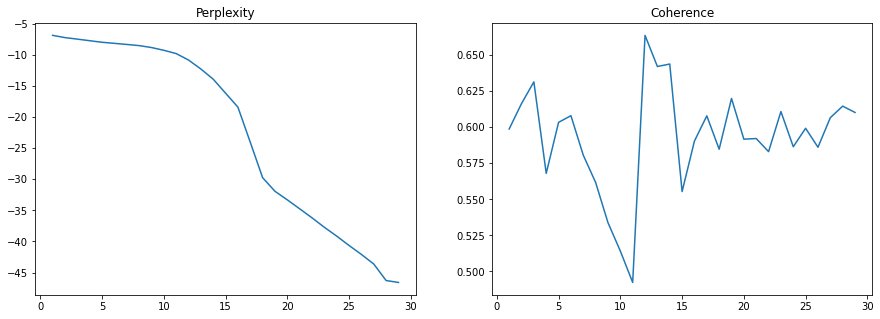

In [13]:
figure, axis = plt.subplots(1, 2, figsize=(15,5))

axis[0].plot(range(1,30), neg_topic_models['per_values'])
axis[0].set_title("Perplexity")
  
axis[1].plot(range(1,30), neg_topic_models['coh_values'])
axis[1].set_title("Coherence")
  
plt.show()

In [14]:
n_topics = 6
lda_model = neg_topic_models['lda_models'][n_topics-1]
dictionary = preprocessed_text['neg_dictionary']

data_frame = pd.DataFrame()
for i in range(n_topics):
    data_frame['Topic'+str(i)] = pd.Series(index=dictionary.values(),data=lda_model.get_topics()[i]).sort_values(ascending=False).index.values
    
data_frame.iloc[:20]

Topic0              Topic1        Topic2            Topic3  \
0        company                 bad            na          security   
1         growth         lot_politic       process       night_shift   
2          shift           difficult          like       contractual   
3           work      permanent_role          good  rotational_shift   
4           team                want    experience             level   
5          month             support            hr       slow_growth   
6       employee   manager_behaviour         happy               low   
7    opportunity           retention      horrible      life_balance   
8           hard                poor         start           politic   
9           time  management_address    department           project   
10        policy          waste_time     permanent            timing   
11        change                   s         tough              hour   
12  compensation               place        expect            period   
13          love       investigation     promotion          terrible   
14        rotate              recall      language              rest   
15        matter                orgs             u             money   
16          role               unity  company_work              boss   
17     interview              attemp            si            salary   
18           fun            training             e              high   
19          have              little      commerce           working   

                  Topic4             Topic5  
0                dislike         management  
1                   feel            problem  
2                 career      career_growth  
3   contractual_employee       basic_salary  
4                  issue           pressure  
5                      ü§ó       dislike_work  
6                      üôÇ  skill_development  
7                      ‚ò∫        environment  
8                     Ô∏èi               slow  
9                 happen               pour  
10                people             totali  
11        management_bad            comment  
12                reason             system  
13                  tell                wlb  
14                   lot            distort  
15              delevery            amazing  
16                   get            compney  
17               satisfy               miss  
18                shoulf             metric  
19                follow           actually

- Employees from first group of comments are most disatisfied with opportunities to carrer growth. Words like: opportunity, carrer growth indicate this
- Employees from second group of comments are most dissatisfied with management. Words like: management, lot politics, managment behaviour indicate this
- Employees from third group of comments are most dissatisfied with experience and promotion. Words like: experience, promotion indicate this
- Employees from fourth group of comments are most dissatisfied with security and work life balance. Words like: security, night shift, life balance indicate this
- Employees from fifth group of comments are most dissatisfied with management. Words like: bad managment indicate this
- Employees from sixth group of comments are most dissatisfied with carrer growth, salary and pressure. Words like: career growth, basic salary, skill development and pressure indicate this

In [15]:
data = pd.DataFrame(columns=['Topic','prob','index'])
for index, i in enumerate(lda_model[preprocessed_text['neg_corpus']]):
    for j in i:
        data.loc[data.shape[0]] = [j[0],j[1],index]
        
data = data.sort_values(by=['Topic','prob'],ascending=[True,False])

for topic in range(n_topics):
    print('Topic {}, most representative comments:'.format(topic))
    comments = data.loc[data.Topic==topic]['index']
    comments = comments[:min(len(comments),5)]
    for comment in comments:
        print('{}: {}'.format(comment, preprocessed_text['neg_texts_comment'][int(comment)].text.strip()))
    print('\n')

Topic 0, most representative comments:
191.0: The process  and tools are outdated. Performance matrics are unjust. It's a kind of work where no matter how hard you put your efforts you'd still be dependent on ratings from moody customers. You'll end up becoming a punching bag which gets punched from both customers and policies.
44.0: Internal team opportunity can be more transparent and some guidance should be provided to help growing within Amazon.
198.0: They are hiring people on contract basis and not giving permanent jobs, which is a major drawback with this company.
139.0: Very very rare chances for your employement to be full time if you join on contract bases
46.0: Compensation is not competitive for non developer roles.


Topic 1, most representative comments:
110.0: They r pushing for quat quality is not good they r firing from company.that is very very bad.
293.0: There are mandatory trainings which were irrelevant or unnecessary for your work field.
92.0: There is a lot of  